In [1]:
!pip install osmnx geopandas matplotlib shapely scipy pyproj



   TIENDA_ID  PLAZA_CVE NIVELSOCIOECONOMICO_DES ENTORNO_DES  MTS2VENTAS_NUM  \
0          1          2                       C       Hogar       109.73693   
1          2          2                       C       Hogar       109.73693   
2          3          2                       C       Hogar       109.73693   
3          4          2                       A       Hogar       109.73693   
4          5          2                       C       Hogar       109.73693   

   PUERTASREFRIG_NUM  CAJONESESTACIONAMIENTO_NUM  LATITUD_NUM  LONGITUD_NUM  \
0               13.0                           8     26.00177     -98.24284   
1               13.0                           8     26.04198     -98.35620   
2               13.0                           8     26.02464     -98.26098   
3               13.0                           8     26.04326     -98.23851   
4               13.0                           8     26.06397     -98.26165   

  SEGMENTO_MAESTRO_DESC LID_UBICACION_TIENDA DATAS

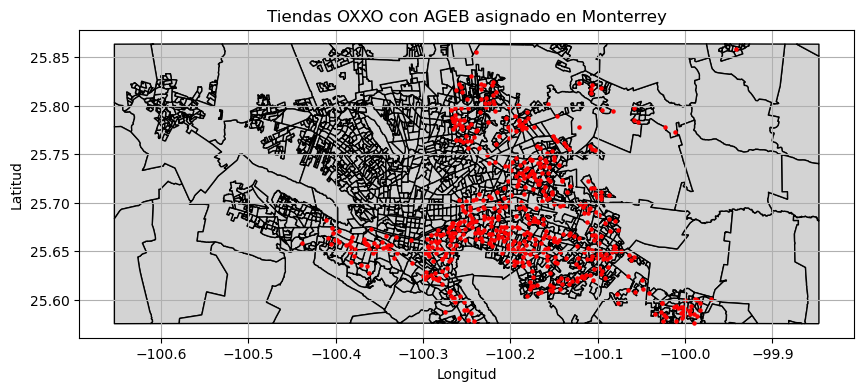

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Carga el shapefile de AGEBs
agebs = gpd.read_file("ageb/INEGI_AGEB_.shp")
tiendas = pd.read_csv("Clean/tienda_limpio_bueno.csv")

# Convertir a GeoDataFrame
tiendas['geometry'] = tiendas.apply(lambda row: Point(row['LONGITUD_NUM'], row['LATITUD_NUM']), axis=1)
tiendas_gdf = gpd.GeoDataFrame(tiendas, geometry='geometry', crs=agebs.crs)

# Hacer join espacial
tiendas_con_ageb = gpd.sjoin(tiendas_gdf, agebs, how='left', predicate='within')

# Ahora tienes cada tienda con su AGEB asignado
print(tiendas_con_ageb.head())
tiendas_en_agebs = tiendas_con_ageb[tiendas_con_ageb['index_right'].notna()].copy()



fig, ax = plt.subplots(figsize=(10, 10))
agebs.plot(ax=ax, color='lightgrey', edgecolor='black')
tiendas_en_agebs.plot(ax=ax, color='red', markersize=5)
ax.set_title("Tiendas OXXO con AGEB asignado en Monterrey")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.show()


In [4]:
tiendas_en_agebs.head()


,TIENDA_ID,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,MET_TARGET,AVG_VENTAS,geometry,index_right,ID,CVEGEO
19,22,6,C,Hogar,78.00000,10.0,8,25.57557,-99.98963,Hogar Reunión,UT_TRAFICO_VEHICULAR,TRAIN,True,935129.574286,POINT (-99.98963 25.57557),282.0,37457,190090001066A
28,32,4,C,Hogar,83.92000,9.0,8,25.66615,-100.13315,Hogar Reunión,UT_DENSIDAD,TRAIN,True,663111.766667,POINT (-100.13315 25.66615),1006.0,38512,1903100010069
33,37,4,D,Hogar,109.93000,12.0,8,25.61395,-100.17367,Hogar Reunión,UT_DENSIDAD,TRAIN,True,638693.899524,POINT (-100.17367 25.61395),1199.0,38566,1903100451122
37,42,6,D,Hogar,92.84000,12.0,7,25.57826,-100.02549,Hogar Reunión,UT_DENSIDAD,TRAIN,True,812077.266190,POINT (-100.02549 25.57826),1064.0,37459,1900900010960
38,43,4,CD,Hogar,109.73693,12.0,8,25.61009,-100.15445,Hogar Reunión,UT_DENSIDAD,TRAIN,True,710157.074762,POINT (-100.15445 25.61009),495.0,38694,1903103131300


# el otro

In [6]:
# ============================================================ #
#  AMM – OXXO ANALYTICS TOOLKIT (versión extendida)
#  ------------------------------------------------------------
#  • Filtra tiendas OXXO dentro del AMM (9 municipios).
#  • Calcula distancias a:
#       – Competidor más cercano (≠ OXXO)
#       – Vialidad principal más cercana
#       – Centro comercial más cercano
#       – Oficina más cercana
#  • Exporta CSV final y genera mapa interactivo en Folium.
# ============================================================ #

# 1) Imports
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
from shapely.geometry import Point
from shapely.ops import unary_union
from scipy.spatial import cKDTree
import numpy as np

# 2) Parámetros / paths
CSV_TIENDAS = "Clean/tienda_limpio_bueno.csv"
OUT_CSV     = "tiendas_AMM_distancias.csv"
MAP_HTML    = "mapa_tiendas_AMM.html"

# 3) Cargar tiendas y convertir a GeoDataFrame
df = pd.read_csv(CSV_TIENDAS)
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["LONGITUD_NUM"], df["LATITUD_NUM"]),
    crs="EPSG:4326"
)

# 4) Definir polígonos de los municipios del AMM
municipios_amm = [
    "Monterrey, Nuevo León, México",
    "San Pedro Garza García, Nuevo León, México",
    "San Nicolás de los Garza, Nuevo León, México",
    "Guadalupe, Nuevo León, México",
    "Apodaca, Nuevo León, México",
    "General Escobedo, Nuevo León, México",
    "Santa Catarina, Nuevo León, México",
    "García, Nuevo León, México",
    "Juárez, Nuevo León, México",
]

polys = []
for muni in municipios_amm:
    try:
        polys.append(ox.geocoder.geocode_to_gdf(muni).iloc[0].geometry)
    except Exception as e:
        print(f"⚠️  No se pudo descargar {muni}: {e}")

amm_poly = unary_union(polys).buffer(0)

# 5) Filtrar tiendas dentro del AMM
gdf_amm = gdf[gdf.within(amm_poly)].copy()
print(f"🏪  Tiendas en CSV: {len(gdf)}   ➜  Dentro del AMM: {len(gdf_amm)}")

# 6) Descargar competidores (tiendas de conveniencia ≠ OXXO)
tags = {"shop": "convenience"}
pois = ox.features_from_polygon(amm_poly, tags)
pois = pois[pois.geometry.type == "Point"]

mask_oxxo = (
    pois.get("brand", "").str.contains("OXXO", case=False, na=False) |
    pois.get("name", "").str.contains("OXXO", case=False, na=False)
)
competitors = pois[~mask_oxxo].copy()
print(f"⚔️  Competidores en AMM: {len(competitors)}")

# 7) Proyección a CRS métrico (UTM)
utm_crs = ox.projection.project_gdf(gdf_amm).crs
gdf_amm_utm     = gdf_amm.to_crs(utm_crs)
competitors_utm = competitors.to_crs(utm_crs)

# 8) Calcular distancia al competidor más cercano
store_xy = np.vstack([gdf_amm_utm.geometry.x, gdf_amm_utm.geometry.y]).T
comp_xy  = np.vstack([competitors_utm.geometry.x, competitors_utm.geometry.y]).T

tree = cKDTree(comp_xy)
dist_comp, idx = tree.query(store_xy, k=1)

gdf_amm_utm["dist_competidor_m"] = dist_comp
gdf_amm["dist_competidor_m"]     = dist_comp

# 9) Calcular distancia a la vialidad principal más cercana
print("⏬  Descargando vialidades principales…")
hwy_types = ["motorway", "motorway_link",
             "trunk", "trunk_link",
             "primary", "primary_link"]

graph = ox.graph_from_polygon(
    amm_poly,
    network_type="drive",
    custom_filter=f'["highway"~"^({"|".join(hwy_types)})$"]'
)

edges = ox.graph_to_gdfs(graph, nodes=False, edges=True, fill_edge_geometry=True)
edges = edges.to_crs(utm_crs)

main_roads = edges.unary_union
gdf_amm_utm["dist_vialidad_m"] = gdf_amm_utm.distance(main_roads)
gdf_amm["dist_vialidad_m"]     = gdf_amm_utm["dist_vialidad_m"].values

print("🚗  Columnas añadidas: dist_competidor_m, dist_vialidad_m")

# 10) Descargar centros comerciales y oficinas desde OSM
print("⏬  Descargando centros comerciales y oficinas…")

# Centros comerciales
tags_malls = {"shop": "mall"}
malls = ox.features_from_polygon(amm_poly, tags_malls)
malls = malls[malls.geometry.type == "Point"].to_crs(utm_crs)

# Oficinas
tags_offices = {"office": True}
offices = ox.features_from_polygon(amm_poly, tags_offices)
offices = offices[offices.geometry.type == "Point"].to_crs(utm_crs)

# 11) Calcular distancias a malls y oficinas
def calc_nearest_distances(source_gdf, target_gdf):
    src_xy = np.vstack([source_gdf.geometry.x, source_gdf.geometry.y]).T
    tgt_xy = np.vstack([target_gdf.geometry.x, target_gdf.geometry.y]).T
    tree = cKDTree(tgt_xy)
    dist, _ = tree.query(src_xy, k=1)
    return dist

# Distancia a malls
if not malls.empty:
    gdf_amm_utm["dist_mall_m"] = calc_nearest_distances(gdf_amm_utm, malls)
    gdf_amm["dist_mall_m"] = gdf_amm_utm["dist_mall_m"].values
    print("🏬  Distancia a mall añadida")
else:
    gdf_amm["dist_mall_m"] = np.nan
    print("⚠️  No se encontraron malls")

# Distancia a oficinas
if not offices.empty:
    gdf_amm_utm["dist_office_m"] = calc_nearest_distances(gdf_amm_utm, offices)
    gdf_amm["dist_office_m"] = gdf_amm_utm["dist_office_m"].values
    print("🏢  Distancia a oficina añadida")
else:
    gdf_amm["dist_office_m"] = np.nan
    print("⚠️  No se encontraron oficinas")

# 12) Exportar CSV final
gdf_amm.drop(columns="geometry").to_csv(OUT_CSV, index=False)
print(f"✅ CSV con distancias guardado en {OUT_CSV}")

# 13) Mapa interactivo en Folium
m = folium.Map(location=[25.6866, -100.3161], zoom_start=11, tiles="OpenStreetMap")

# OXXO – puntos rojos con popup
for _, r in gdf_amm.iterrows():
    folium.CircleMarker(
        location=[r["LATITUD_NUM"], r["LONGITUD_NUM"]],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=0.8,
        popup=(f"TIENDA_ID: {r['TIENDA_ID']}<br>"
               f"Dist. competidor: {r['dist_competidor_m']:.0f} m<br>"
               f"Dist. vialidad: {r['dist_vialidad_m']:.0f} m<br>"
               f"Dist. mall: {r['dist_mall_m']:.0f} m<br>"
               f"Dist. oficina: {r['dist_office_m']:.0f} m")
    ).add_to(m)

# Competidores – puntos azules
for _, r in competitors.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=4,
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m.save(MAP_HTML)
print(f"🗺️  Mapa interactivo guardado en {MAP_HTML} – ábrelo en tu navegador")


🏪  Tiendas en CSV: 946   ➜  Dentro del AMM: 537
⚔️  Competidores en AMM: 232
⏬  Descargando vialidades principales…
🚗  Columnas añadidas: dist_competidor_m, dist_vialidad_m
⏬  Descargando centros comerciales y oficinas…
🏬  Distancia a mall añadida
🏢  Distancia a oficina añadida
✅ CSV con distancias guardado en tiendas_AMM_distancias.csv
🗺️  Mapa interactivo guardado en mapa_tiendas_AMM.html – ábrelo en tu navegador


In [7]:
gdf_amm.shape

(537, 19)

In [8]:
print(gdf_amm.iloc[0])

TIENDA_ID                                              32
PLAZA_CVE                                               4
NIVELSOCIOECONOMICO_DES                                 C
ENTORNO_DES                                         Hogar
MTS2VENTAS_NUM                                      83.92
PUERTASREFRIG_NUM                                     9.0
CAJONESESTACIONAMIENTO_NUM                              8
LATITUD_NUM                                      25.66615
LONGITUD_NUM                                   -100.13315
SEGMENTO_MAESTRO_DESC                       Hogar Reunión
LID_UBICACION_TIENDA                          UT_DENSIDAD
DATASET                                             TRAIN
MET_TARGET                                           True
AVG_VENTAS                                  663111.766667
geometry                      POINT (-100.13315 25.66615)
dist_competidor_m                             1678.246008
dist_vialidad_m                               1000.796982
dist_mall_m   

In [9]:
pip install catboost lightgbm xgboost scikit-learn pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [10]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Cargar dataset
df = pd.read_csv('tiendas_AMM_distancias.csv')

# Separar variable target
target = 'AVG_VENTAS'
y = df[target]
X = df.drop(columns=[target])

# Identificar variables categóricas reales
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Asegurar que están presentes en el DataFrame
cat_cols = [col for col in cat_cols if col in X.columns]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de CatBoost
cb_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

# Entrenamiento
cb_model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test), verbose=100)

# Predicción y evaluación
y_pred_cb = cb_model.predict(X_test)
rmse_cb = mean_squared_error(y_test, y_pred_cb, squared=False)

from sklearn.metrics import r2_score

r2_cb = r2_score(y_test, y_pred_cb)
print(f"CatBoost RMSE: {rmse_cb:.2f}")
print(f"CatBoost R^2: {r2_cb:.2f}")


0:	learn: 419570.5854828	test: 380427.8854190	best: 380427.8854190 (0)	total: 61ms	remaining: 1m
100:	learn: 271190.4707957	test: 297313.7442641	best: 297313.7442641 (100)	total: 167ms	remaining: 1.49s
200:	learn: 213475.4350706	test: 297151.3950705	best: 294961.5490986 (152)	total: 293ms	remaining: 1.16s
300:	learn: 169324.8787383	test: 300876.9216913	best: 294961.5490986 (152)	total: 411ms	remaining: 954ms
400:	learn: 138067.0464032	test: 303228.6551600	best: 294961.5490986 (152)	total: 531ms	remaining: 793ms
500:	learn: 117033.2951660	test: 303618.6023806	best: 294961.5490986 (152)	total: 648ms	remaining: 646ms
600:	learn: 98096.2067346	test: 304601.2845792	best: 294961.5490986 (152)	total: 765ms	remaining: 508ms
700:	learn: 84190.8397986	test: 304642.5822746	best: 294961.5490986 (152)	total: 880ms	remaining: 375ms
800:	learn: 72991.3142026	test: 305585.1038419	best: 294961.5490986 (152)	total: 999ms	remaining: 248ms
900:	learn: 63899.2197868	test: 306309.9202332	best: 294961.549098

/Users/javier/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/javier/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/javier/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/javier/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

# Modelo

Shrink model to first 153 iterations.

CatBoost RMSE: 294961.55

CatBoost R^2: 0.41



🔝 Top 15 features más importantes:
                    Feature  Importance
8              LONGITUD_NUM   16.583612
0                 TIENDA_ID   14.247752
12               MET_TARGET    8.824967
7               LATITUD_NUM    7.640512
4            MTS2VENTAS_NUM    7.107283
13        dist_competidor_m    6.500904
15              dist_mall_m    6.105979
2   NIVELSOCIOECONOMICO_DES    5.389587
14          dist_vialidad_m    4.871226
16            dist_office_m    4.428352
1                 PLAZA_CVE    4.228641
10     LID_UBICACION_TIENDA    3.785880
3               ENTORNO_DES    3.697897
9     SEGMENTO_MAESTRO_DESC    3.531710
5         PUERTASREFRIG_NUM    2.057805


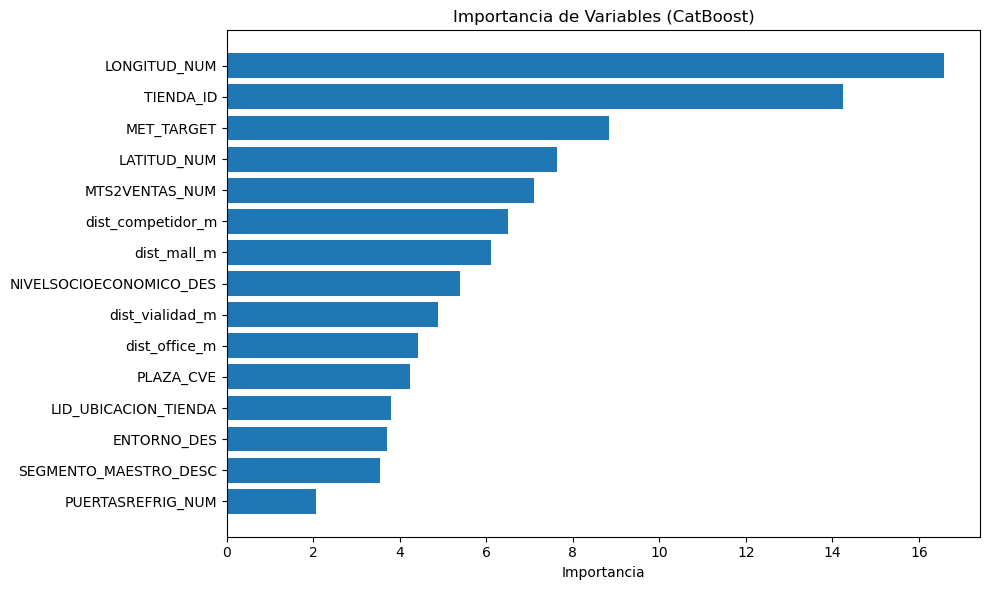

In [11]:
# Obtener importancia de variables
importances = cb_model.get_feature_importance()
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las top 15
print("\n🔝 Top 15 features más importantes:")
print(importance_df.head(15))

# Opcional: gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(15)[::-1], importance_df['Importance'].head(15)[::-1])
plt.title('Importancia de Variables (CatBoost)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()
